# Libraries

In [1]:
##importing libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import math
import gzip
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_multilabel_classification, make_classification, make_blobs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
import scipy.stats as st
from collections import Counter
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Simulated Data Generation

In [102]:
"""Generate Simulated Data"""

def generate_data(n, d):
    
    #np.random.seed(1)
    phi_1 = 0.3
    phi_2 = 0.4
    phi_3 = 0.3
    mu_0 = 1 * np.arange(0, d, 1)
    mu_1 = 2 * np.arange(0, d, 1)
    mu_2 = 3 * np.arange(0, d, 1)
    
    X = np.empty((n, d))
    y = np.random.choice([0, 1, 2], size=(n, 1), p=[phi_1, phi_2, phi_3])
    
    tmp = np.random.randn(d, d)
    evals = np.diag(np.concatenate((100 * np.random.randn(round(d/8),1), np.random.randn(d - round(d/8),1))) ** 2)
    sigma = np.eye(d, d)
    row, col = np.diag_indices_from(sigma)
    sigma[row, col] = evals.flatten()
    
    for i in range(len(y)):
        if y[i] == 0:
            X[i] = np.random.multivariate_normal(mu_0, sigma, 1)
        elif y[i] == 1:
            X[i] = np.random.multivariate_normal(mu_1, sigma, 1)
        else: 
            X[i] = np.random.multivariate_normal(mu_2, sigma, 1)
    
    return X, y

In [203]:
#Generating simulated data - 1
"""
simulated data with evals = diag([100 ∗ randn(round(d/8), 1).2; randn(d − round(d/8), 1)^2])
"""
#np.random.seed(1)
n = 100
d = 10

X, y = generate_data(n, d)
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
##Split generated dataset into training set (80%) and validatation set (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

##Split training set (80%) in two parts - for training (70%) and testing (30%)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=0.3, random_state=12)

print("***Simulated Dataset***")
print("Number of Datapoints (n) : "+str(n))
print("Number of Features (d) : "+str(d))
print("Shape of X (Input/Features) : "+str(X.shape))
print("Shape of y (output/class labels) : "+str(y.shape))
print("\n***Splitting Dataset into Training and Validation Sets***")
print("Shape of Training Data (X_train, y_train): "+str(X_train.shape)+", "+str(y_train.shape))
print("Shape of Validation Data (X_val, y_val): "+str(X_val.shape)+", "+str(y_val.shape))
print("\n***Splitting Training Dataset into Training and Testing Sets***")
print("Shape of Training Data (X_train, y_train): "+str(X_train1.shape)+", "+str(y_train1.shape))
print("Shape of Test Data (X_test, y_test): "+str(X_test1.shape)+", "+str(y_test1.shape))



***Simulated Dataset***
Number of Datapoints (n) : 100
Number of Features (d) : 10
Shape of X (Input/Features) : (100, 10)
Shape of y (output/class labels) : (100, 1)

***Splitting Dataset into Training and Validation Sets***
Shape of Training Data (X_train, y_train): (80, 10), (80, 1)
Shape of Validation Data (X_val, y_val): (20, 10), (20, 1)

***Splitting Training Dataset into Training and Testing Sets***
Shape of Training Data (X_train, y_train): (56, 10), (56, 1)
Shape of Test Data (X_test, y_test): (24, 10), (24, 1)


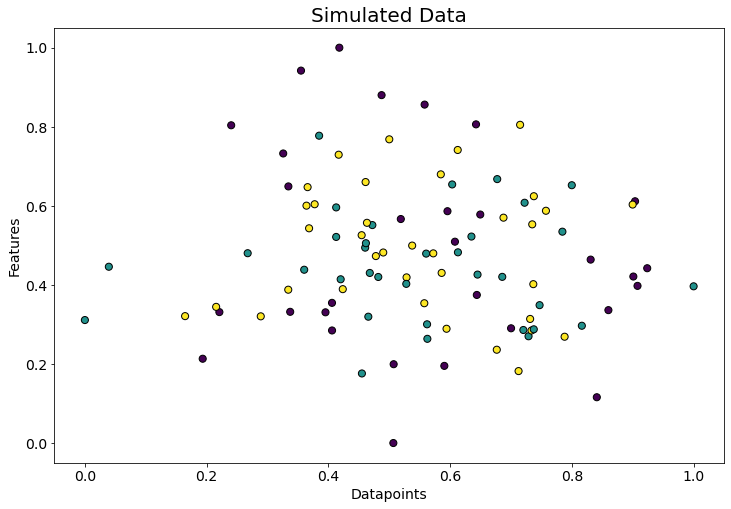

In [214]:
plt.figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=50, edgecolor="k")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams.update({'font.size': 14})
plt.xlabel('Datapoints')
plt.ylabel('Features')
#plt.legend(loc='best',ncol=1, frameon=True, shadow=True, fontsize=14)
plt.title("Simulated Data", fontsize=20)
plt.show()

In [8]:
def calculate_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    #print(accuracy)
    precision = precision_score(y_test, y_pred, average='weighted')
    #print(precision)
    recall = recall_score(y_test, y_pred, average='weighted')
    #print(recall)
    f1 = f1_score(y_test, y_pred, average='weighted')
    #print(f1)
    
    return accuracy, precision, recall, f1

# Multinomial Logistic Regression without PCA

In [190]:
#define MLR model and fit dataset
def logistic_regression(X, y, X_test, y_test, X_val, y_val):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, penalty='l2', C=1.0)
    model.fit(X, y)
    y_pred_train = model.predict(X)
    train_mse = mean_squared_error(y, y_pred_train)
    
    y_pred_test = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    y_pred_val = model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_pred_val)
    
    train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(y, y_pred_train)
    test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(y_test, y_pred_test)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(y_val, y_pred_val)
    
    table = [['Dataset', 'Accuracy','Precision', 'Recall', 'F1 Score'],
             ['Training', train_accuracy, train_precision, train_recall, train_f1],
             ['Testing', test_accuracy, test_precision, test_recall, test_f1],
             ['Validation', val_accuracy, val_precision, val_recall, val_f1]]
    
    
    #print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
    
    return test_mse, test_accuracy, table

In [115]:
print("\n***Logistic Regression without PCA***")
mse, accuracy, table = logistic_regression(X_train1, y_train1, X_test1, y_test1, X_val, y_val)
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


***Logistic Regression without PCA***
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.982143 │    0.982955 │ 0.982143 │   0.982133 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.916667 │    0.933333 │ 0.916667 │   0.916088 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.85     │    0.885455 │ 0.85     │   0.856461 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛


# Naive Bayes Classifier without PCA

In [381]:
#Naive bayes
def naive_bayes(X, y, X_test, y_test, X_val, y_val):
    model = MultinomialNB()
    model.fit(X, y)
    y_pred_train = model.predict(X)
    train_mse = mean_squared_error(y, y_pred_train)
    
    y_pred_test = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    y_pred_val = model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_pred_val)
    
    train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(y, y_pred_train)
    test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(y_test, y_pred_test)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(y_val, y_pred_val)
    
    table = [['Dataset', 'Accuracy','Precision', 'Recall', 'F1 Score'],
             ['Training', train_accuracy, train_precision, train_recall, train_f1],
             ['Testing', test_accuracy, test_precision, test_recall, test_f1],
             ['Validation', val_accuracy, val_precision, val_recall, val_f1]]
    
    
    #print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
    
    return test_mse, test_accuracy, table

In [116]:
print("\n***Naive Bayes without PCA***")
mse, accuracy, table = naive_bayes(X_train1, y_train1, X_test1, y_test1, X_val, y_val)
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


***Naive Bayes without PCA***
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.678571 │    0.542857 │ 0.678571 │   0.59375  │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.458333 │    0.335185 │ 0.458333 │   0.383578 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.75     │    0.573529 │ 0.75     │   0.646552 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛


# Multi-class Neural Network without PCA

In [399]:
# Neural network
def neural_network(X, y, X_test, y_test, X_val, y_val):
    model = Sequential()
    model.add(Dense(1000, input_dim=len(X[0]), activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    #compile the keras model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    #fit the keras model on the dataset
    #print("***Training Started***\n")
    model.fit(X, y, epochs=60, batch_size=10, shuffle=True, verbose=0)
    #print("\n***Training Complete***")
    
    # predict crisp classes for test set
    y_pred_train = model.predict(X)
    y_pred_test = model.predict(X_test)
    y_pred_val = model.predict(X_val)
    
    #Converting predictions to label
    pred_train = list()
    pred_test = list()
    pred_val = list()
    for i in range(len(y_pred_train)):
        pred_train.append(np.argmax(y_pred_train[i]))
        
    for i in range(len(y_pred_test)):
        pred_test.append(np.argmax(y_pred_test[i]))
        
    for i in range(len(y_pred_val)):
        pred_val.append(np.argmax(y_pred_val[i]))
    
    #Converting one hot encoded test label to label
    train = list()
    test = list()
    val = list()
    for i in range(len(y)):
        train.append(np.argmax(y[i]))
    
    for i in range(len(y_test)):
        test.append(np.argmax(y_test[i]))
    
    for i in range(len(y_val)):
        val.append(np.argmax(y_val[i]))
        
    train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(train, pred_train)
    test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(test, pred_test)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(val, pred_val)
    
    # evaluate the keras model
    train_mse, _ = model.evaluate(X_test, y_test, verbose=0)
    test_mse, _ = model.evaluate(X_test, y_test, verbose=0)
    val_mse, _ = model.evaluate(X_test, y_test, verbose=0)
   
    table = [['Dataset', 'Accuracy','Precision', 'Recall', 'F1 Score'],
             ['Training', train_accuracy, train_precision, train_recall, train_f1],
             ['Testing', test_accuracy, test_precision, test_recall, test_f1],
             ['Validation', val_accuracy, val_precision, val_recall, val_f1]]
    
    #print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
    
    return test_mse, test_accuracy, table

In [177]:
print("\n***Neural Network without PCA***")
mse, accuracy, table = neural_network(X_train1, y_train1, X_test1, y_test1, X_val, y_val)
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


***Neural Network without PCA***
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.964286 │           1 │ 0.964286 │   0.981818 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   1        │           1 │ 1        │   1        │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.95     │           1 │ 0.95     │   0.974359 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛


# Data visualization (without PCA)

In [420]:
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
categories = [*categories, categories[0]]
test_LR_wo_PCA = [np.round(100*0.916667), np.round(100*0.933333), np.round(100*0.916667), np.round(100*0.916088)]
test_NB_wo_PCA = [np.round(100*0.458333), np.round(100*0.335185), np.round(100*0.458333), np.round(100*0.383578)]
test_NN_wo_PCA = [np.round(100*1), np.round(100*1), np.round(100*1), np.round(100*1)]
test_LR_wo_PCA = [*test_LR_wo_PCA, test_LR_wo_PCA[0]]
test_NB_wo_PCA = [*test_NB_wo_PCA, test_NB_wo_PCA[0]]
test_NN_wo_PCA = [*test_NN_wo_PCA, test_NN_wo_PCA[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=test_LR_wo_PCA, theta=categories, name='Logistic Regression'),
        go.Scatterpolar(r=test_NB_wo_PCA, theta=categories, name='Naive Bayes'),
        go.Scatterpolar(r=test_NN_wo_PCA, theta=categories, name='Neural Network')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='ML Algorithm Comparison without PCA (Testing Set)'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

plotly.offline.iplot(fig)

val_LR_wo_PCA = [np.round(100*0.85), np.round(100*0.885455), np.round(100*0.85), np.round(100*0.856461)]
val_NB_wo_PCA = [np.round(100*0.75), np.round(100*0.573529), np.round(100*0.75), np.round(100*0.646552)]
val_NN_wo_PCA = [np.round(100*0.95), np.round(100*1), np.round(100*0.95), np.round(100*1)]
val_LR_wo_PCA = [*val_LR_wo_PCA, val_LR_wo_PCA[0]]
val_NB_wo_PCA = [*val_NB_wo_PCA, val_NB_wo_PCA[0]]
val_NN_wo_PCA = [*val_NN_wo_PCA, val_NN_wo_PCA[0]]

fig2 = go.Figure(
    data=[
        go.Scatterpolar(r=val_LR_wo_PCA, theta=categories, name='Logistic Regression'),
        go.Scatterpolar(r=val_NB_wo_PCA, theta=categories, name='Naive Bayes'),
        go.Scatterpolar(r=val_NN_wo_PCA, theta=categories, name='Neural Network')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='ML Algorithm Comparison without PCA (Validation Set)'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

plotly.offline.iplot(fig2)

# PCA Pre-preprocessing

In [178]:
"""Select best 'r' after applying PCA"""

def select_rank_r(X, y, X_test, y_test, X_val, y_val, method):
    """
    return an optimal rank of the approximation matrix based on the test MSE and a plot of test MSE against the number of features
    return: r is the optimal rank of the approximation matrix
    """

    if X.shape[0] != y.shape[0]:
        raise Exception("X and y must have the same dimension")
    elif X_test.shape[0] != y_test.shape[0]:
        raise Exception("X_test and y_test must have the same dimension")
    max_iter = 1000
    alpha = 1e-2
    m = X.shape[0]
    n = X.shape[1]
    one_mat = np.ones((n,1))
    #print(one_mat.shape)
    #mu_hat = np.sum(X) / X.shape[0]
    mu_hat = X.mean(axis=0)
    #print(mu_hat.shape)
    Z = X - np.dot(mu_hat.T, one_mat)
    #print(Z.shape)
    U_full, S_full, V_full = np.linalg.svd(Z)

    test_error = []
    accuracy = []
    table_data = []
    for i in range(1, X.shape[1]):
        V = np.transpose(V_full)[:, 0:i]
        B = np.dot(X, V)
        #print(B.shape)
        #adding mean term
        c_hat = np.ones(B.shape[0]).reshape(B.shape[0], 1)
        B = np.concatenate((c_hat, B), axis=1)
        #print(B.shape)
        #print('B = ', B.shape)
        if method == 'Logistic Regression':
            #y_hat = estimate_logistic_reg(B[:, 0:(i+1)], y_test, max_iter, alpha)
            error_metric, test_accuracy, table = logistic_regression(B[:, 0:(i+1)], y, X_test[:, 0:(i+1)], y_test, X_val[:, 0:(i+1)], y_val)
            accuracy.append(test_accuracy)
            table_data.append(table)
            
        if method == 'Naive Bayes':
            min_max_scaler = preprocessing.MinMaxScaler()
            B = min_max_scaler.fit_transform(B)
            error_metric, test_accuracy, table = naive_bayes(B[:, 0:(i+1)], y, X_test[:, 0:(i+1)], y_test, X_val[:, 0:(i+1)], y_val)
            accuracy.append(test_accuracy)
            table_data.append(table)
            
        if method == 'Neural Network':
            #y_hat = estimate_logistic_reg(B[:, 0:(i+1)], y_test, max_iter, alpha)
            error_metric, test_accuracy, table = neural_network(B[:, 0:(i+1)], y, X_test[:, 0:(i+1)], y_test, X_val[:, 0:(i+1)], y_val)
            accuracy.append(test_accuracy)
            table_data.append(table)
            
        #print(error_metric)
        test_error.append(error_metric)

    r = np.argmin(test_error) + 1

    return r, test_error, accuracy, table_data

def plot_figure(test_mse, accuracy):
    plt.figure(figsize=(12,8))
    plt.plot(test_mse, label='Test Error', linestyle='--', marker='o')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('Features')
    plt.ylabel('Test Error')
    #plt.legend(loc='best',ncol=1, frameon=True, shadow=True, fontsize=14)
    plt.title("Testing Data Error per number of Principal Components", fontsize=20)
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.plot(accuracy, label='Accuracy', linestyle='--', marker='o')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('Features')
    plt.ylabel('Accuracy')
    #plt.legend(loc='best',ncol=1, frameon=True, shadow=True, fontsize=14)
    plt.title("Testing Data Accuracy per number of Principal Components", fontsize=20)
    plt.show()

# Multinomial Logistic Regression with PCA


***Logistic Regression with PCA***
Best value of r for Logistic Regression with PCA =  5
Minimum value of error for Logistic Regression with PCA =  0.75
Accuracy of Logistic Regression with PCA =  0.5


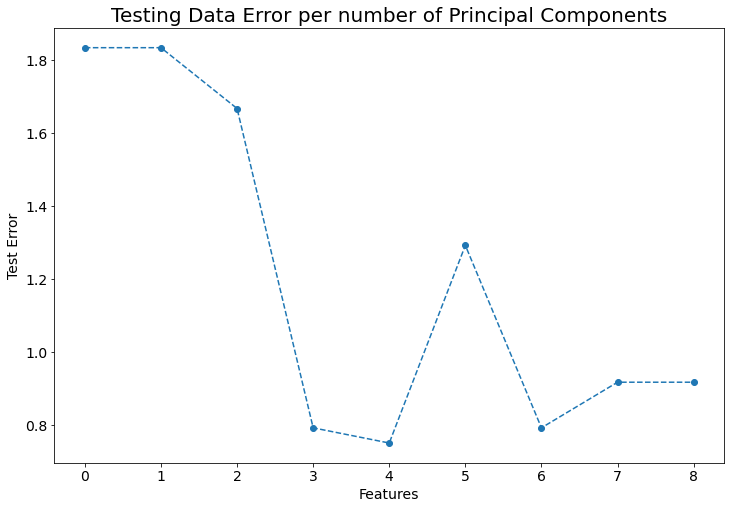

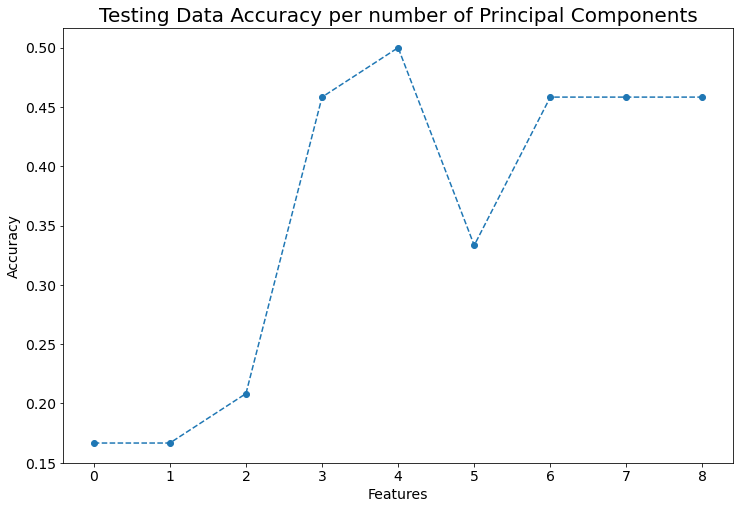

In [191]:
r1, test_error1, accuracy1, table_data1 = select_rank_r(X_train1, y_train1, X_test1, y_test1, X_val, y_val, method='Logistic Regression')
print("\n***Logistic Regression with PCA***")
print('Best value of r for Logistic Regression with PCA = ', r1)
print('Minimum value of error for Logistic Regression with PCA = ', min(test_error1))
print('Accuracy of Logistic Regression with PCA = ', max(accuracy1))
table = table_data1[r1-1]
#print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
plot_figure(test_error1, accuracy1)

In [125]:
#Printing all confusion matrixes to compare with best value of r
r1, test_error1, accuracy1, table_data = select_rank_r(X_train1, y_train1, X_test1, y_test1, X_val, y_val, method='Logistic Regression')

╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.375    │   0.345982  │ 0.375    │   0.345352 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.166667 │   0.0277778 │ 0.166667 │   0.047619 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.5      │   0.25      │ 0.5      │   0.333333 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.446429 │   0.441542  │ 0.446429 │   0.428657 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.166667 │   0.0277778 │ 0.166667 │   0.047619 │
├─────────

# Naive Bayes Classifier with PCA


***Naive Bayes with PCA***
Best value of r for Naive Bayes with PCA =  6
Minimum value of error for Naive Bayes with PCA =  1.2083333333333333
Accuracy of Naive Bayes with PCA =  0.4583333333333333


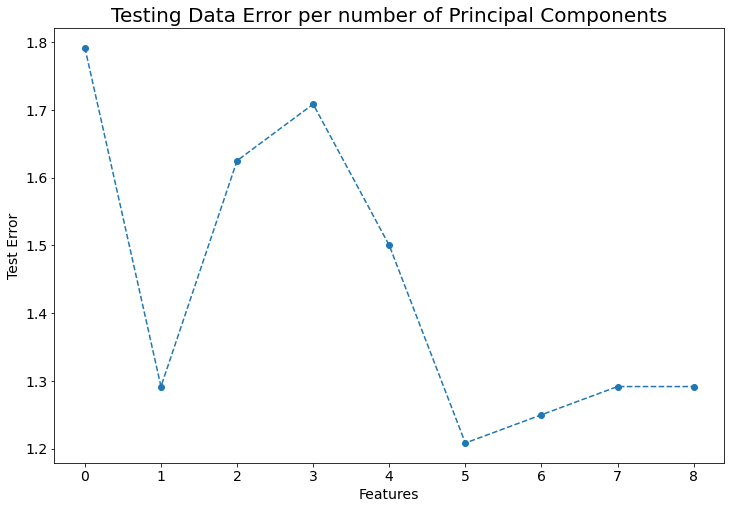

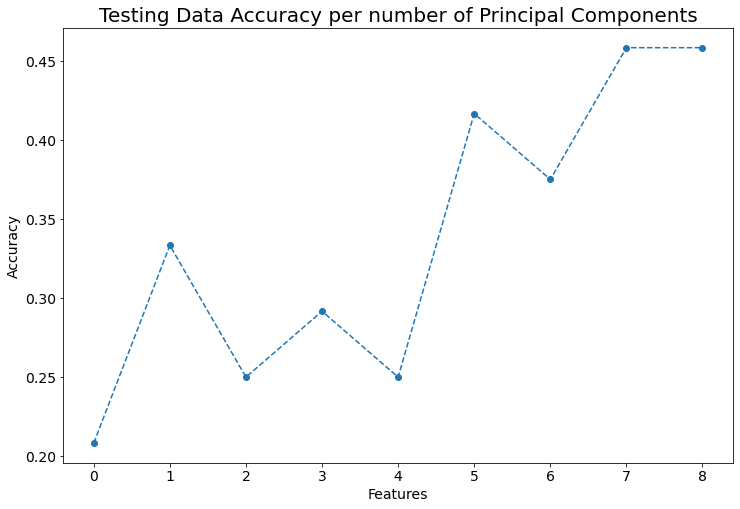

In [188]:
r2, test_error2, accuracy2, table_data2 = select_rank_r(X_train1, y_train1, X_test1, y_test1, X_val, y_val, method='Naive Bayes')
print("\n***Naive Bayes with PCA***")
print('Best value of r for Naive Bayes with PCA = ', r2)
print('Minimum value of error for Naive Bayes with PCA = ', min(test_error2))
print('Accuracy of Naive Bayes with PCA = ', max(accuracy2))
table = table_data2[r2-1]
#print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
plot_figure(test_error2, accuracy2)

In [95]:
#Printing all confusion matrixes to compare with best value of r
r2, test_error2, accuracy2, table_data2 = select_rank_r(X_train1, y_train1, X_test1, y_test1, X_val, y_val, method='Naive Bayes')

╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.357143 │    0.456494 │ 0.357143 │   0.208156 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.208333 │    0.528986 │ 0.208333 │   0.126306 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.5      │    0.25     │ 0.5      │   0.333333 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.339286 │    0.2288   │ 0.339286 │   0.272967 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.333333 │    0.298368 │ 0.333333 │   0.300085 │
├─────────

# Multi-class Neural Network with PCA


***Neural Network with PCA***
Best value of r for Neural Network with PCA =  5
Minimum value of error for Neural Network with PCA =  1.1666961908340454
Accuracy of Neural Network with PCA =  0.75


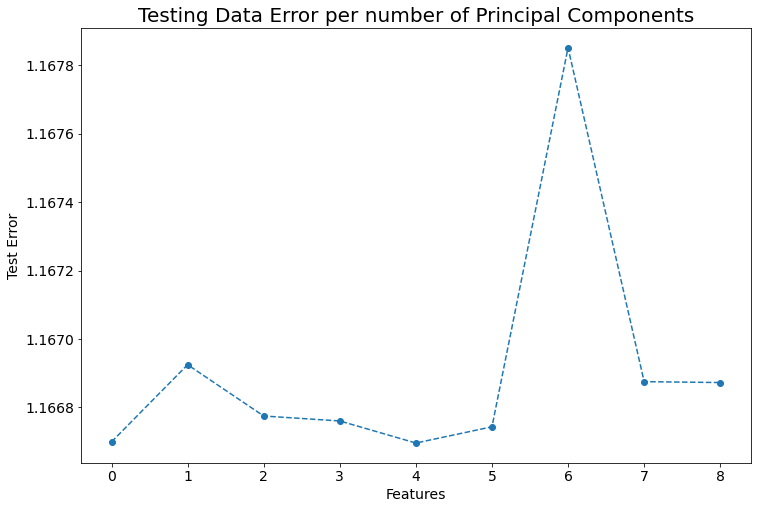

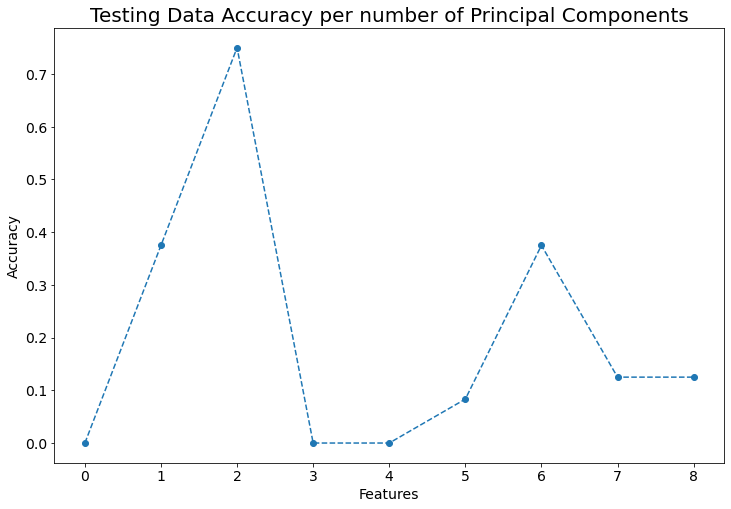

In [184]:
r3, test_error3, accuracy3, table_data3 = select_rank_r(X_train1, y_train1, X_test1, y_test1, X_val, y_val, method='Neural Network')
print("\n***Neural Network with PCA***")
print('Best value of r for Neural Network with PCA = ', r3)
print('Minimum value of error for Neural Network with PCA = ', min(test_error3))
print('Accuracy of Neural Network with PCA = ', max(accuracy3))
table = table_data2[r3-1]
#print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
plot_figure(test_error3, accuracy3)

In [187]:
#Printing all confusion matrixes to compare with best value of r
r3, test_error3, accuracy3, table_data3 = select_rank_r(X_train1, y_train1, X_test1, y_test1, X_val, y_val, method='Neural Network')

╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │          0 │           0 │        0 │          0 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │          0 │           0 │        0 │          0 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │          0 │           0 │        0 │          0 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.267857 │           1 │ 0.267857 │   0.422535 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0        │           0 │ 0        │   0        │
├─────────

# Data visualization with PCA

In [421]:
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
categories = [*categories, categories[0]]
test_LR_w_PCA = [np.round(100*0.5), np.round(100*0.386111), np.round(100*0.5), np.round(100*0.404356)]
test_NB_w_PCA = [np.round(100*0.458333), np.round(100*0.440171), np.round(100*0.458333), np.round(100*0.411765)]
test_NN_w_PCA = [np.round(100*0.916667), np.round(100*1), np.round(100*0.916667), np.round(100*1)]
test_LR_w_PCA = [*test_LR_wo_PCA, test_LR_wo_PCA[0]]
test_NB_w_PCA = [*test_NB_wo_PCA, test_NB_wo_PCA[0]]
test_NN_w_PCA = [*test_NN_wo_PCA, test_NN_wo_PCA[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=test_LR_w_PCA, theta=categories, name='Logistic Regression'),
        go.Scatterpolar(r=test_NB_w_PCA, theta=categories, name='Naive Bayes'),
        go.Scatterpolar(r=test_NN_w_PCA, theta=categories, name='Neural Network')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='ML Algorithm Comparison with PCA (Testing Set)'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

plotly.offline.iplot(fig)

val_LR_w_PCA = [np.round(100*0.35), np.round(100*0.1225), np.round(100*0.35), np.round(100*0.181481)]
val_NB_w_PCA = [np.round(100*0.25), np.round(100*0.2375), np.round(100*0.25), np.round(100*0.243333)]
val_NN_w_PCA = [np.round(100*0.9), np.round(100*1), np.round(100*0.9), np.round(100*0.947386)]
val_LR_w_PCA = [*val_LR_w_PCA, val_LR_w_PCA[0]]
val_NB_w_PCA = [*val_NB_w_PCA, val_NB_w_PCA[0]]
val_NN_w_PCA = [*val_NN_w_PCA, val_NN_w_PCA[0]]

fig2 = go.Figure(
    data=[
        go.Scatterpolar(r=val_LR_w_PCA, theta=categories, name='Logistic Regression'),
        go.Scatterpolar(r=val_NB_w_PCA, theta=categories, name='Naive Bayes'),
        go.Scatterpolar(r=val_NN_w_PCA, theta=categories, name='Neural Network')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='ML Algorithm Comparison with PCA (Validation Set)'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

plotly.offline.iplot(fig2)

# Real Data

In [393]:
##Importing the real data
#np.random.seed(12)
df = pd.read_csv(r'C:\Users\soura\Box\Spring 2022\EE 425\Project\Proposal\data10.csv')
print("\n***ICS Cyber Attack Dataset***\n")
print('Original Dataset shape : ', df.shape, '\n')

print("Displaying first five rows of Data:\n")
print(df.head())

#Removing columns with infinity and NaN values
print("\n***Removing columns with infinity and NaN values***")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, inplace=True)
print('Modified Dataset shape : ', df.shape)
print('Count of each class labels : ', Counter(df['marker']))
df['marker'] = df['marker'].replace(["NoEvents", "Natural", "Attack"], [0, 1, 2])
#df.loc[~(df==0).all(axis=1)]

data = df.to_numpy()
#print('Dataset shape : ', data.shape)

#print(data[:, n])
#data = clean_dataset(data_csv)

#Normalizing dataset
n = data.shape[1] - 1
X = data[:, 0:n]
y = data[:, n]
#X, removed_cols = remove_zero_columns(X)
#y = np.delete(y, removed_cols, 1)
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

#pca = PCA(svd_solver='arpack')
#pca.fit_transform(X)
X = X[:,~np.all(X == 0, axis = 0)]
print("\nShape of X (Input/Features) : "+str(X.shape))
print("Shape of y (output/class labels) : "+str(y.shape))
#print('Count of each class labels : ', Counter(df['marker']))
#print('Count of each class labels : ', Counter(y))
#print(pca.n_components_)

##Split generated dataset into training set (80%) and validatation set (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

##Split training set (80%) in two parts - for training (70%) and testing (30%)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=0.3, random_state=12)

print("\n***Splitting Dataset into Training and Validation Sets***")
print("Shape of Training Data (X_train, y_train): "+str(X_train.shape)+", "+str(y_train.shape))
print("Shape of Validation Data (X_val, y_val): "+str(X_val.shape)+", "+str(y_val.shape))
print("\n***Splitting Training Dataset into Training and Testing Sets***")
print("Shape of Training Data (X_train, y_train): "+str(X_train1.shape)+", "+str(y_train1.shape))
print("Shape of Test Data (X_test, y_test): "+str(X_test1.shape)+", "+str(y_test1.shape))


***ICS Cyber Attack Dataset***

Original Dataset shape :  (5569, 129) 

Displaying first five rows of Data:

   R1-PA1:VH     R1-PM1:V   R1-PA2:VH     R1-PM2:V   R1-PA3:VH     R1-PM3:V  \
0 -19.858717  130531.4436 -139.847539  130506.3704  100.147293  130606.6634   
1 -18.821664  131083.0556 -138.787567  131057.9823  101.195806  131133.2021   
2 -18.546644  131333.7883 -138.518277  131308.7150  101.476555  131383.9348   
3 -18.254435  131584.5210 -138.231798  131559.4477  101.768764  131634.6675   
4 -18.128385  131634.6675 -138.094288  131584.5210  101.883355  131684.8140   

   R1-PA4:IH   R1-PM4:I   R1-PA5:IH   R1-PM5:I  ...  control_panel_log4  \
0 -19.572238  419.50501 -143.050373  438.18223  ...                   0   
1 -18.867500  420.42056 -141.875809  436.16802  ...                   0   
2 -18.781557  420.96989 -141.514846  435.06936  ...                   0   
3 -18.735720  421.70233 -141.251285  434.70314  ...                   0   
4 -19.033658  423.89965 -141.119505  434

# Logistic Regression, Naive Bayes & Neural Network without PCA on Real Data

In [313]:
print("\n***Logistic Regression on Real Data without PCA***")
mse, accuracy, table = logistic_regression(X_train1, y_train1, X_test1, y_test1, X_val, y_val)
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


***Logistic Regression on Real Data without PCA***
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.710924 │    0.709309 │ 0.710924 │   0.603076 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.705979 │    0.686665 │ 0.705979 │   0.599407 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.717797 │    0.682237 │ 0.717797 │   0.615698 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛


In [314]:
print("\n***Naive Bayes on Real Data without PCA***")
mse, accuracy, table = naive_bayes(X_train1, y_train1, X_test1, y_test1, X_val, y_val)
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


***Naive Bayes on Real Data without PCA***
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.703899 │    0.73003  │ 0.703899 │   0.582347 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.698608 │    0.489025 │ 0.698608 │   0.575324 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.714848 │    0.512214 │ 0.714848 │   0.596799 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛


In [277]:
print("\n***Neural Network on Real Data without PCA***")
mse, accuracy, table = neural_network(X_train1, y_train1, X_test1, y_test1, X_val, y_val)
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


***Neural Network on Real Data without PCA***
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.865121 │           1 │ 0.865121 │   0.927684 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.832105 │           1 │ 0.832105 │   0.908359 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.825959 │           1 │ 0.825959 │   0.904685 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛


# Data visualization without PCA

In [422]:
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
categories = [*categories, categories[0]]
test_LR_wo_PCA = [np.round(100*0.705979), np.round(100*0.686665), np.round(100*0.705979), np.round(100*0.599407)]
test_NB_wo_PCA = [np.round(100*0.698608), np.round(100*0.489025), np.round(100*0.698608), np.round(100*0.575324)]
test_NN_wo_PCA = [np.round(100*0.832105), np.round(100*1), np.round(100*0.832105), np.round(100*0.908359)]
test_LR_wo_PCA = [*test_LR_wo_PCA, test_LR_wo_PCA[0]]
test_NB_wo_PCA = [*test_NB_wo_PCA, test_NB_wo_PCA[0]]
test_NN_wo_PCA = [*test_NN_wo_PCA, test_NN_wo_PCA[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=test_LR_wo_PCA, theta=categories, name='Logistic Regression'),
        go.Scatterpolar(r=test_NB_wo_PCA, theta=categories, name='Naive Bayes'),
        go.Scatterpolar(r=test_NN_wo_PCA, theta=categories, name='Neural Network')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='ML Algorithm Comparison without PCA (Testing Set)'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

plotly.offline.iplot(fig)

val_LR_wo_PCA = [np.round(100*0.717797), np.round(100*0.682237), np.round(100*0.717797), np.round(100*0.615698)]
val_NB_wo_PCA = [np.round(100* 0.714848), np.round(100*0.512214), np.round(100* 0.714848), np.round(100*0.596799)]
val_NN_wo_PCA = [np.round(100*0.825959), np.round(100*1), np.round(100*0.825959), np.round(100*0.904685)]
val_LR_wo_PCA = [*val_LR_wo_PCA, val_LR_wo_PCA[0]]
val_NB_wo_PCA = [*val_NB_wo_PCA, val_NB_wo_PCA[0]]
val_NN_wo_PCA = [*val_NN_wo_PCA, val_NN_wo_PCA[0]]

fig2 = go.Figure(
    data=[
        go.Scatterpolar(r=val_LR_wo_PCA, theta=categories, name='Logistic Regression'),
        go.Scatterpolar(r=val_NB_wo_PCA, theta=categories, name='Naive Bayes'),
        go.Scatterpolar(r=val_NN_wo_PCA, theta=categories, name='Neural Network')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='ML Algorithm Comparison without PCA (Validation Set)'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

plotly.offline.iplot(fig2)

# Logistic Regression, Naive Bayes & Neural Network with PCA on Real Data

In [378]:
from sklearn import *
def select_rank_r_PCA(X, y, X_test, y_test, X_val, y_val, method):
    """
    return an optimal rank of the approximation matrix based on the test MSE and a plot of test MSE against the number of features
    return: r is the optimal rank of the approximation matrix
    """

    if X.shape[0] != y.shape[0]:
        raise Exception("X and y must have the same dimension")
    elif X_test.shape[0] != y_test.shape[0]:
        raise Exception("X_test and y_test must have the same dimension")
    max_iter = 1000
    alpha = 1e-2
    m = X.shape[0]
    n = X.shape[1]
    one_mat = np.ones((n,1))
    #print(one_mat.shape)
    #mu_hat = np.sum(X) / X.shape[0]
    mu_hat = X.mean(axis=0)
    #print(mu_hat.shape)
    Z = X - np.dot(mu_hat.T, one_mat)
    #print(Z.shape)
    U_full, S_full, V_full = np.linalg.svd(Z)
    comp = min(X.shape[0], X.shape[1])
    test_error = []
    accuracy = []
    table_data = []
    for i in range(1, X.shape[1]):
        pca = PCA(svd_solver='arpack')
        pca.fit(X)
        X = pca.transform(X)
        X_test = pca.transform(X_test)
        X_val = pca.transform(X_val)
        #print(X.shape)
        if method == 'Logistic Regression':
            #y_hat = estimate_logistic_reg(B[:, 0:(i+1)], y_test, max_iter, alpha)
            error_metric, test_accuracy, table = logistic_regression(X[:, 0:(i+1)], y, X_test[:, 0:(i+1)], y_test, X_val[:, 0:(i+1)], y_val)
            accuracy.append(test_accuracy)
            table_data.append(table)
            
        if method == 'Naive Bayes':
            min_max_scaler = preprocessing.MinMaxScaler()
            X = min_max_scaler.fit_transform(X)
            error_metric, test_accuracy, table = naive_bayes(X[:, 0:(i+1)], y, X_test[:, 0:(i+1)], y_test, X_val[:, 0:(i+1)], y_val)
            accuracy.append(test_accuracy)
            table_data.append(table)
            
        if method == 'Neural Network':
            #y_hat = estimate_logistic_reg(B[:, 0:(i+1)], y_test, max_iter, alpha)
            error_metric, test_accuracy, table = neural_network(X[:, 0:(i+1)], y, X_test[:, 0:(i+1)], y_test, X_val[:, 0:(i+1)], y_val)
            accuracy.append(test_accuracy)
            table_data.append(table)
            
        #print(error_metric)
        test_error.append(error_metric)

    r = np.argmin(test_error) + 1

    return r, test_error, accuracy, table_data


***Logistic Regression with PCA***
Best value of r for Logistic Regression with PCA =  23
Minimum value of error for Logistic Regression with PCA =  0.4742014742014742
Accuracy of Logistic Regression with PCA =  0.7059787059787059
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.709168 │    0.697815 │ 0.709168 │   0.598083 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.70516  │    0.680368 │ 0.70516  │   0.595224 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.720747 │    0.698275 │ 0.720747 │   0.615674 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛


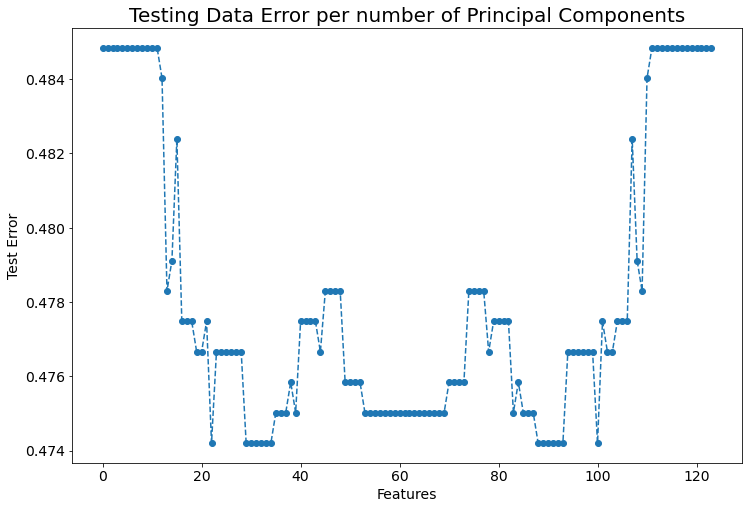

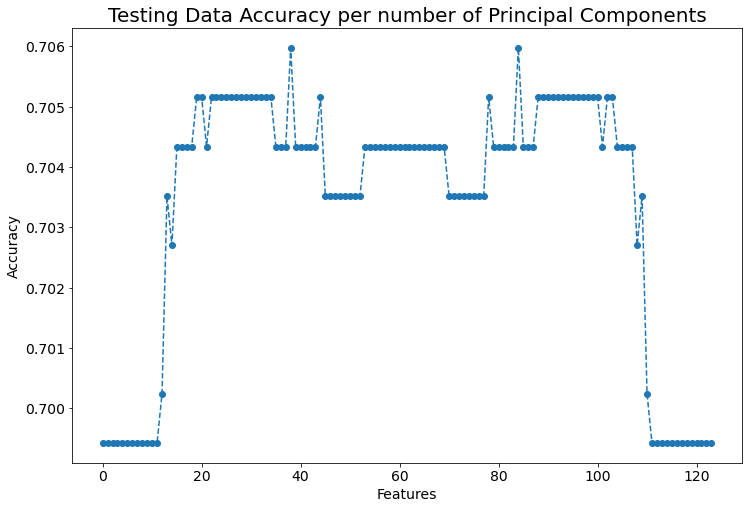

In [374]:
r1, test_error1, accuracy1, table_data1 = select_rank_r_PCA(X_train1, y_train1, X_test1, y_test1, X_val, y_val, method='Logistic Regression')
print("\n***Logistic Regression with PCA***")
print('Best value of r for Logistic Regression with PCA = ', r1)
print('Minimum value of error for Logistic Regression with PCA = ', min(test_error1))
print('Accuracy of Logistic Regression with PCA = ', max(accuracy1))
table = table_data1[r1]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
plot_figure(test_error1, accuracy1)


***Naive Bayes with PCA***
Best value of r for Naive Bayes with PCA =  22
Minimum value of error for Naive Bayes with PCA =  0.48157248157248156
Accuracy of Naive Bayes with PCA =  0.7002457002457002
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.703899 │    0.495474 │ 0.703899 │   0.581576 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.700246 │    0.52539  │ 0.700246 │   0.581633 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.714848 │    0.547268 │ 0.714848 │   0.604688 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛


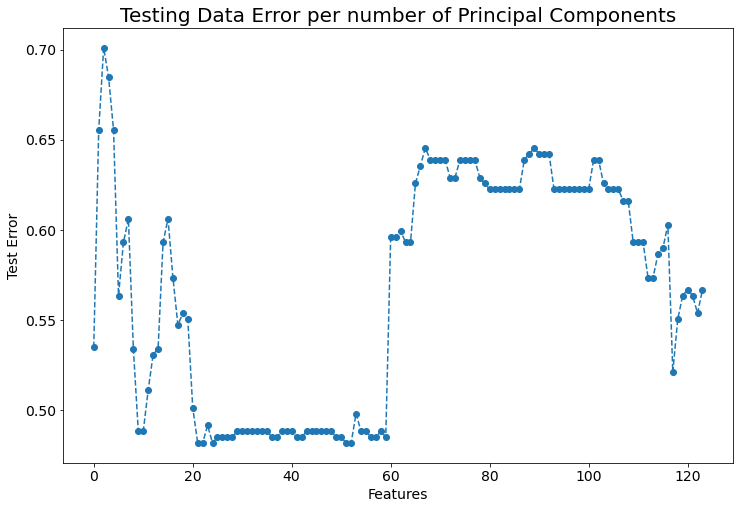

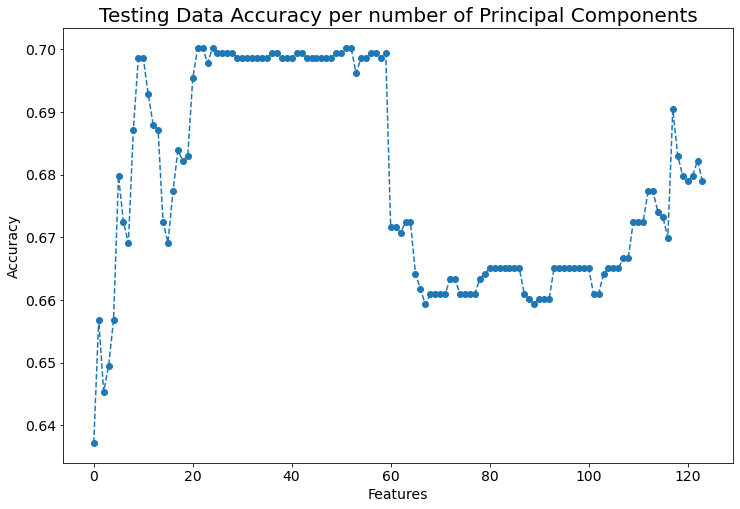

In [389]:
r2, test_error2, accuracy2, table_data2 = select_rank_r_PCA(X_train1, y_train1, X_test1, y_test1, X_val, y_val, method='Naive Bayes')
print("\n***Naive Bayes with PCA***")
print('Best value of r for Naive Bayes with PCA = ', r2)
print('Minimum value of error for Naive Bayes with PCA = ', min(test_error2))
print('Accuracy of Naive Bayes with PCA = ', max(accuracy2))
table = table_data2[r2]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
plot_figure(test_error2, accuracy2)

╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.131015 │           1 │ 0.131015 │   0.231677 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.117117 │           1 │ 0.117117 │   0.209677 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.127827 │           1 │ 0.127827 │   0.226678 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.352652 │           1 │ 0.352652 │   0.521423 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.382473 │           1 │ 0.382473 │   0.553318 │
├─────────

╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.198455 │           1 │ 0.198455 │   0.331184 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.203931 │           1 │ 0.203931 │   0.338776 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.221239 │           1 │ 0.221239 │   0.362319 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.58026  │           1 │ 0.58026  │   0.734385 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.576577 │           1 │ 0.576577 │   0.731429 │
├─────────

╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.547243 │           1 │ 0.547243 │   0.707378 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.531532 │           1 │ 0.531532 │   0.694118 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.523107 │           1 │ 0.523107 │   0.686895 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.148929 │           1 │ 0.148929 │   0.259248 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.143325 │           1 │ 0.143325 │   0.250716 │
├─────────

╒════════════╤════════════╤═════════════╤═══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │    Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪═══════════╪════════════╡
│ Training   │  0.0604145 │           1 │ 0.0604145 │   0.113945 │
├────────────┼────────────┼─────────────┼───────────┼────────────┤
│ Testing    │  0.0769861 │           1 │ 0.0769861 │   0.142966 │
├────────────┼────────────┼─────────────┼───────────┼────────────┤
│ Validation │  0.0776794 │           1 │ 0.0776794 │   0.144161 │
╘════════════╧════════════╧═════════════╧═══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.347383 │           1 │ 0.347383 │   0.515641 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.371007 │           1 │ 0.371007 │   0.541219 │
├

╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.311907 │           1 │ 0.311907 │   0.475502 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.30303  │           1 │ 0.30303  │   0.465116 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.294985 │           1 │ 0.294985 │   0.455581 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.341061 │           1 │ 0.341061 │   0.508643 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.341523 │           1 │ 0.341523 │   0.509158 │
├─────────

╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.545838 │           1 │ 0.545838 │   0.706203 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.545455 │           1 │ 0.545455 │   0.705882 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.549656 │           1 │ 0.549656 │   0.709391 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.297506 │           1 │ 0.297506 │   0.458581 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.318591 │           1 │ 0.318591 │   0.48323  │
├─────────

╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.456621 │           1 │ 0.456621 │   0.626959 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.439803 │           1 │ 0.439803 │   0.610922 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.447394 │           1 │ 0.447394 │   0.618207 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.328767 │           1 │ 0.328767 │   0.494845 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.330057 │           1 │ 0.330057 │   0.496305 │
├─────────

╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.250439 │           1 │ 0.250439 │   0.400562 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.244881 │           1 │ 0.244881 │   0.393421 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.252704 │           1 │ 0.252704 │   0.403454 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.45908  │           1 │ 0.45908  │   0.629273 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.443898 │           1 │ 0.443898 │   0.614861 │
├─────────

╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.379347 │           1 │ 0.379347 │   0.550038 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.38493  │           1 │ 0.38493  │   0.555884 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Validation │   0.405113 │           1 │ 0.405113 │   0.576627 │
╘════════════╧════════════╧═════════════╧══════════╧════════════╛
╒════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Dataset    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Training   │   0.23393  │           1 │ 0.23393  │   0.379163 │
├────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Testing    │   0.224406 │           1 │ 0.224406 │   0.366555 │
├─────────

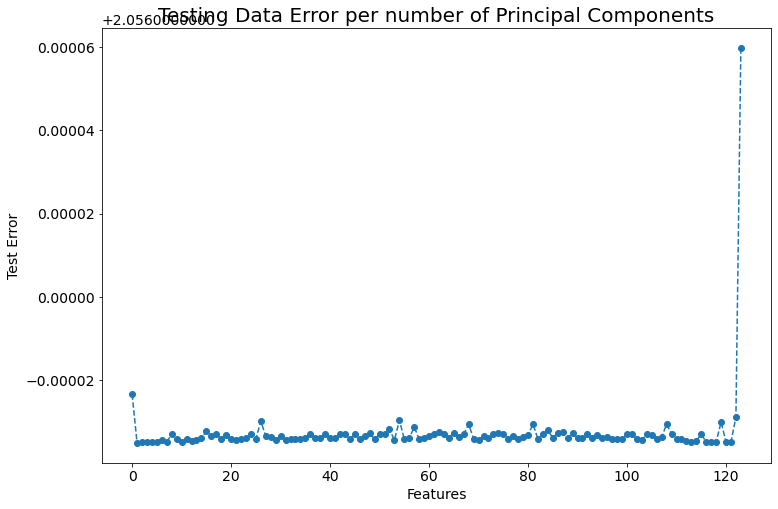

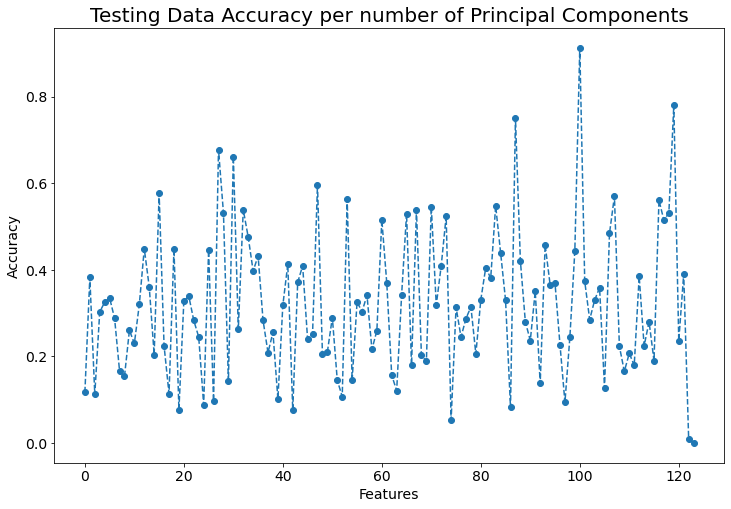

In [398]:
r3, test_error3, accuracy3, table_data3 = select_rank_r_PCA(X_train1, y_train1, X_test1, y_test1, X_val, y_val, method='Neural Network')
r3 = np.argmax(accuracy3)
print("\n***Neural Network with PCA***")
print('Best value of r for Neural Network with PCA = ', r3)
print('Minimum value of error for Neural Network with PCA = ', min(test_error3))
print('Accuracy of Neural Network with PCA = ', max(accuracy3))
#table = table_data2[r3]
#print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
plot_figure(test_error3, accuracy3)

# Data visualization with PCA

In [423]:
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
categories = [*categories, categories[0]]
test_LR_w_PCA = [np.round(100*0.70516), np.round(100*0.680368), np.round(100*0.70516), np.round(100*0.595224)]
test_NB_w_PCA = [np.round(100*0.700246), np.round(100*0.440171), np.round(100*0.700246), np.round(100*0.581633)]
test_NN_w_PCA = [np.round(100*0.913186), np.round(100*1), np.round(100*0.913186), np.round(100*0.954623)]
test_LR_w_PCA = [*test_LR_wo_PCA, test_LR_wo_PCA[0]]
test_NB_w_PCA = [*test_NB_wo_PCA, test_NB_wo_PCA[0]]
test_NN_w_PCA = [*test_NN_wo_PCA, test_NN_wo_PCA[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=test_LR_w_PCA, theta=categories, name='Logistic Regression'),
        go.Scatterpolar(r=test_NB_w_PCA, theta=categories, name='Naive Bayes'),
        go.Scatterpolar(r=test_NN_w_PCA, theta=categories, name='Neural Network')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='ML Algorithm Comparison with PCA (Testing Set)'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

plotly.offline.iplot(fig)

val_LR_w_PCA = [np.round(100*0.720747), np.round(100*0.52539), np.round(100*0.720747), np.round(100*0.615674)]
val_NB_w_PCA = [np.round(100*0.714848), np.round(100*0.547268), np.round(100*0.714848), np.round(100*0.604688)]
val_NN_w_PCA = [np.round(100*0.901672), np.round(100*1), np.round(100*0.901672), np.round(100*0.948294)]
val_LR_w_PCA = [*val_LR_w_PCA, val_LR_w_PCA[0]]
val_NB_w_PCA = [*val_NB_w_PCA, val_NB_w_PCA[0]]
val_NN_w_PCA = [*val_NN_w_PCA, val_NN_w_PCA[0]]

fig2 = go.Figure(
    data=[
        go.Scatterpolar(r=val_LR_w_PCA, theta=categories, name='Logistic Regression'),
        go.Scatterpolar(r=val_NB_w_PCA, theta=categories, name='Naive Bayes'),
        go.Scatterpolar(r=val_NN_w_PCA, theta=categories, name='Neural Network')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='ML Algorithm Comparison with PCA (Validation Set)'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

plotly.offline.iplot(fig2)